<a href="https://colab.research.google.com/github/mikexie360/data-visualization-final-project/blob/main/data_visualization_making_radarcharts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, os, matplotlib as mpl
import seaborn as sns
from google.colab import files


In [76]:
teams_df = pd.read_csv("teams.csv")
team_hero_df = pd.read_csv("team_hero_df.csv")
heroes_df = pd.read_csv("heroes.csv")


print(teams_df.head())
print(team_hero_df.head())
print(heroes_df.head())

   team_id          name         tag   rating  wins  losses  last_match_time  \
0  7119388   Team Spirit     TSpirit  1578.63   768     512       1752941276   
1  9572001    PARIVISION  PARIVISION  1559.36   179      91       1753691348   
2  8255888  BetBoom Team     BetBoom  1547.12   502     405       1753694464   
3  7412785  CyberBonch-1          CB  1520.12   267       1       1639928575   
4  8605863        Cloud9          C9  1497.49   326     243       1726305637   

    last_match_time_iso                                           logo_url  
0  2025-07-19T16:07:56Z  https://cdn.steamusercontent.com/ugc/183917912...  
1  2025-07-28T08:29:08Z  https://cdn.steamusercontent.com/ugc/247650869...  
2  2025-07-28T09:21:04Z  https://cdn.steamusercontent.com/ugc/999542643...  
3  2021-12-19T15:42:55Z  https://cdn.steamusercontent.com/ugc/184253787...  
4  2024-09-14T09:20:37Z  https://cdn.steamusercontent.com/ugc/239994188...  
   team_id  hero_id                        name primary_a

In [77]:
sns.set_theme(style="whitegrid")  # seaborn styling

heroes = pd.read_csv("heroes.csv")
team_hero = pd.read_csv("team_hero_df.csv")
teams = pd.read_csv("teams.csv")

# Normalize key names
if "hero_id" not in heroes.columns and "id" in heroes.columns:
    heroes = heroes.rename(columns={"id": "hero_id"})

# Pick likely name columns
hero_name_col = "localized_name" if "localized_name" in heroes.columns else "name"
team_name_col = "name" if "name" in teams.columns else ("team_name" if "team_name" in teams.columns else "tag")

# Build a consistent, global list of all hero spokes (sorted by name)
ALL_HEROES = (
    heroes[["hero_id", hero_name_col]]
    .rename(columns={hero_name_col: "hero_name"})
    .drop_duplicates()
    .sort_values("hero_name")["hero_name"]
    .astype(str).str.strip()
    .tolist()
)
print(len(ALL_HEROES), ALL_HEROES[:10])

# Merge: team_hero -> heroes (hero_name) -> teams (team_name)
merged = team_hero.merge(
    heroes[["hero_id", hero_name_col]].rename(columns={hero_name_col: "hero_name"}),
    on="hero_id",
    how="left"
).merge(
    teams[["team_id", team_name_col]].rename(columns={team_name_col: "team_name"}),
    on="team_id",
    how="left"
)

# Metric: prefer winrate; compute if missing
if "winrate" not in merged.columns and {"wins","games_played"} <= set(merged.columns):
    merged["winrate"] = merged["wins"] / merged["games_played"].replace(0, np.nan)

merged["hero_name"] = merged["hero_name"].astype(str).str.strip()

# Quick peek
merged.head()

126 ['Abaddon', 'Alchemist', 'Ancient Apparition', 'Anti-Mage', 'Arc Warden', 'Axe', 'Bane', 'Batrider', 'Beastmaster', 'Bloodseeker']


team_id  hero_id                        name primary_attr attack_type  \
0  7119388       19          npc_dota_hero_tiny          str       Melee   
1  7119388       86        npc_dota_hero_rubick          int      Ranged   
2  7119388      129          npc_dota_hero_mars          str       Melee   
3  7119388       17  npc_dota_hero_storm_spirit          int      Ranged   
4  7119388      106  npc_dota_hero_ember_spirit          agi       Melee   

   games_played  wins  winrate localized_name_x localized_name_y  \
0           171   111   0.6491             Tiny             Tiny   
1           162    95   0.5864           Rubick           Rubick   
2           147    84   0.5714             Mars             Mars   
3           125    84   0.6720     Storm Spirit     Storm Spirit   
4           117    73   0.6239     Ember Spirit     Ember Spirit   

      hero_name    team_name  
0          Tiny  Team Spirit  
1        Rubick  Team Spirit  
2          Mars  Team Spirit  
3  Storm Spirit  Team Spirit  
4  Ember Spirit  Team Spirit

In [78]:
def list_teams(df=merged):
    return df[["team_id","team_name"]].drop_duplicates().sort_values("team_name")


In [79]:
def aggregate_team_hero(df_team: pd.DataFrame, value_col: str) -> pd.Series:
    """
    Returns a Series indexed by hero_name with ONE numeric value per hero.
    - winrate: weighted by games_played = sum(wins)/sum(games_played)
    - games_played: sum of games_played
    - else: mean of value_col
    """
    # ensure numeric
    for c in ["wins", "games_played", value_col]:
        if c in df_team.columns:
            df_team[c] = pd.to_numeric(df_team[c], errors="coerce")

    if value_col == "winrate" and {"wins","games_played"} <= set(df_team.columns):
        g = df_team.groupby("hero_name", as_index=True)[["wins","games_played"]].sum()
        s = g["wins"] / (g["games_played"] + .1)
    elif value_col == "games_played":
        s = df_team.groupby("hero_name", as_index=True)["games_played"].sum()
    else:
        s = df_team.groupby("hero_name", as_index=True)[value_col].mean()


    # clean & clip
    s = s.astype(float)
    if value_col == "winrate":
        s = s.clip(0, 1)
    return s

In [105]:
def _angles_for(n):
    ang = np.linspace(0, 2*np.pi, n, endpoint=False).tolist()
    ang += ang[:1]
    return ang

def _close(vals):
    v = list(vals)
    if v:
        v += v[:1]
    return v

def plot_team_radar(team_name, value_col="winrate", top_n=12, all_heroes=True, show_every=1, labelsize=8,show_title=True,
                    show_hero_labels=True,   # theta labels around the circle
                    show_r_ticks=True,       # radial tick labels (0.2, 0.4, …)
                    show_grid=True,
                    show_frame=True,         # polar outer circle
                    axis_off=False,          # master kill switch
                    fill_alpha=0.15,
                    line_width=2):
    df = merged[merged["team_name"] == team_name].copy()
    if df.empty:
        raise ValueError(f"No rows found for team '{team_name}'.")

    if all_heroes:
        # 1 number per hero
        s = aggregate_team_hero(df, value_col)
        # Align to ALL_HEROES so EVERY hero is a spoke
        cats = ALL_HEROES[:]   # built earlier from heroes.csv
        vals = s.reindex(cats, fill_value=0.0).to_numpy(dtype=float)

        # Normalize if plotting counts
        if value_col == "games_played":
            vmax = np.nanmax(vals)
            vals = (vals / vmax) if vmax and np.isfinite(vmax) else vals
            y_label = "games_played (normalized)"
        else:
            # winrate already clipped to [0,1] in aggregator
            y_label = "winrate"
    else:
        # Top-N heroes actually played
        sort_key = "games_played" if "games_played" in df.columns else value_col
        df = df.dropna(subset=["hero_name", value_col]).sort_values(sort_key, ascending=False).head(top_n)

        # Aggregate in case even top-N still has dups
        s = aggregate_team_hero(df, value_col)
        cats = list(s.index)
        if len(cats) < 3:
            raise ValueError(f"Need at least 3 heroes; got {len(cats)} for '{team_name}'.")
        vals = s.to_numpy(dtype=float)

        if value_col == "games_played":
            vmax = np.nanmax(vals)
            vals = (vals / vmax) if vmax and np.isfinite(vmax) else vals
            y_label = "games_played (normalized)"
        else:
            y_label = "winrate"

    angles = _angles_for(len(cats))
    vals_loop = _close(vals)

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)

    # Thin out labels if needed
    step = max(1, int(show_every))
    ax.set_thetagrids(np.degrees(angles[:-1])[::step], [cats[i] for i in range(0, len(cats), step)])
    ax.tick_params(axis="x", labelsize=labelsize)
    ax.set_ylim(0, 1)

    ax.plot(angles, vals_loop, linewidth=2)
    ax.fill(angles, vals_loop, alpha=0.15)
    # ax.set_title(f"{team_name} — {y_label} by Hero ({'ALL heroes' if all_heroes else f'Top {len(cats)}'})", va="bottom")
    ax.set_title(label=f"{team_name} — {y_label}'s Hero Pool Radar Chart Shape", va="bottom",y=1.10, pad=12)

    if not show_hero_labels:
        ax.set_xticklabels([])         # hide hero names

    # --- radial tick labels ---
    if not show_r_ticks:
        ax.set_yticklabels([])         # hide numbers
        ax.set_yticks([])              # and the ticks

    # --- grid & frame ---
    if not show_grid:
        ax.grid(False)                 # hide both theta & radial grids
    if not show_frame:
        ax.spines["polar"].set_visible(False)

    # --- draw data ---
    ax.plot(angles, vals_loop, linewidth=line_width)
    ax.fill(angles, vals_loop, alpha=fill_alpha)

    # --- title ---
    if not show_title:
        ax.set_title(f"",
                     y=0, pad=0)

    # --- nuke everything (but keep the polygon) ---
    if axis_off:
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

16


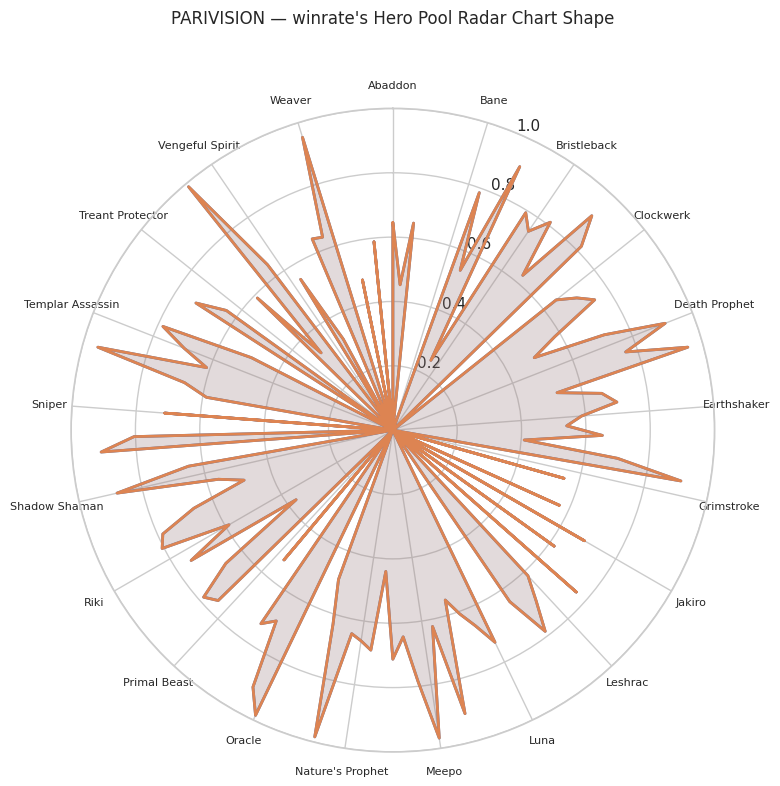

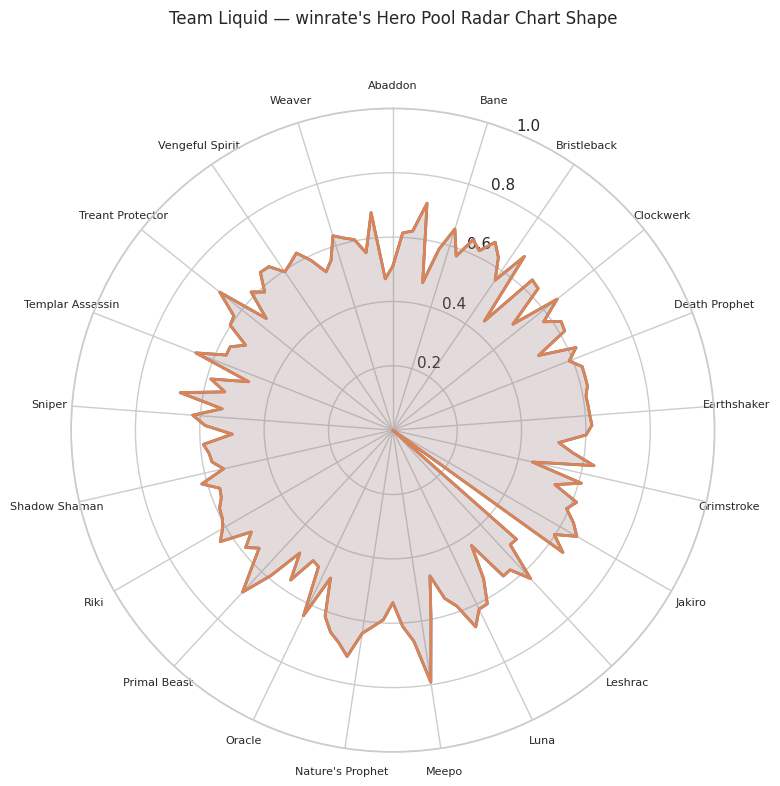

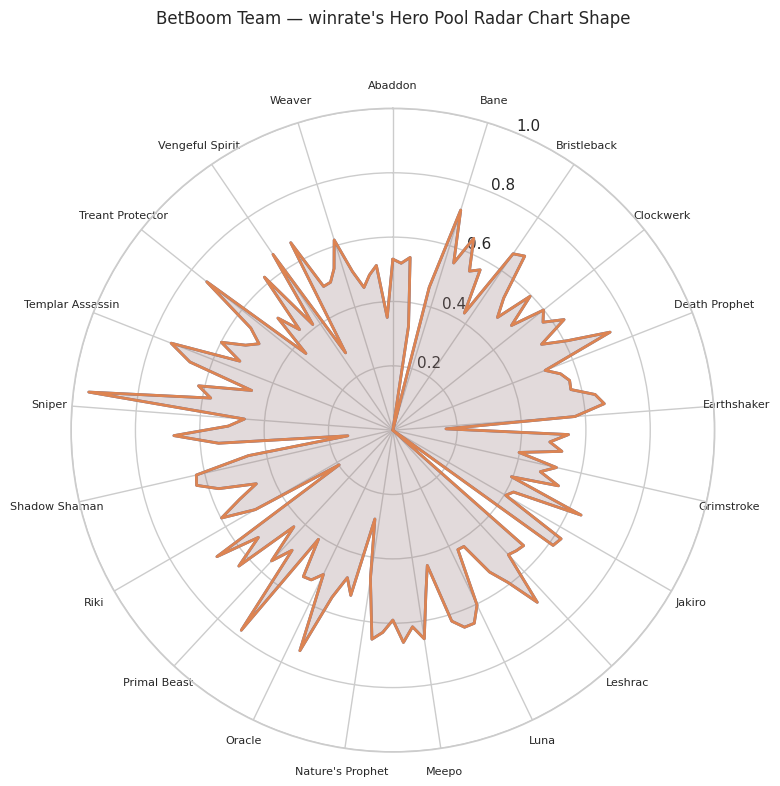

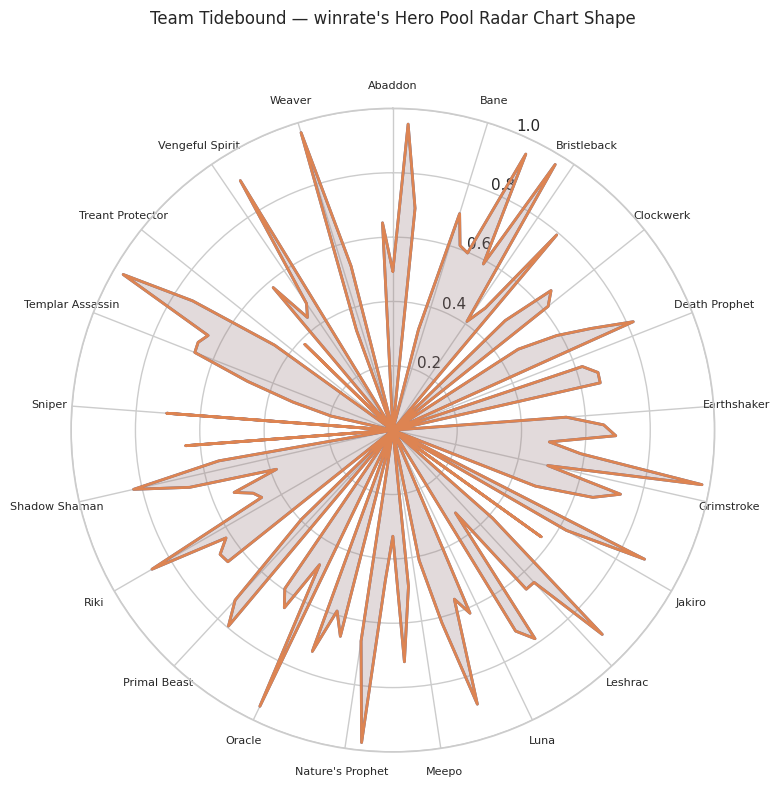

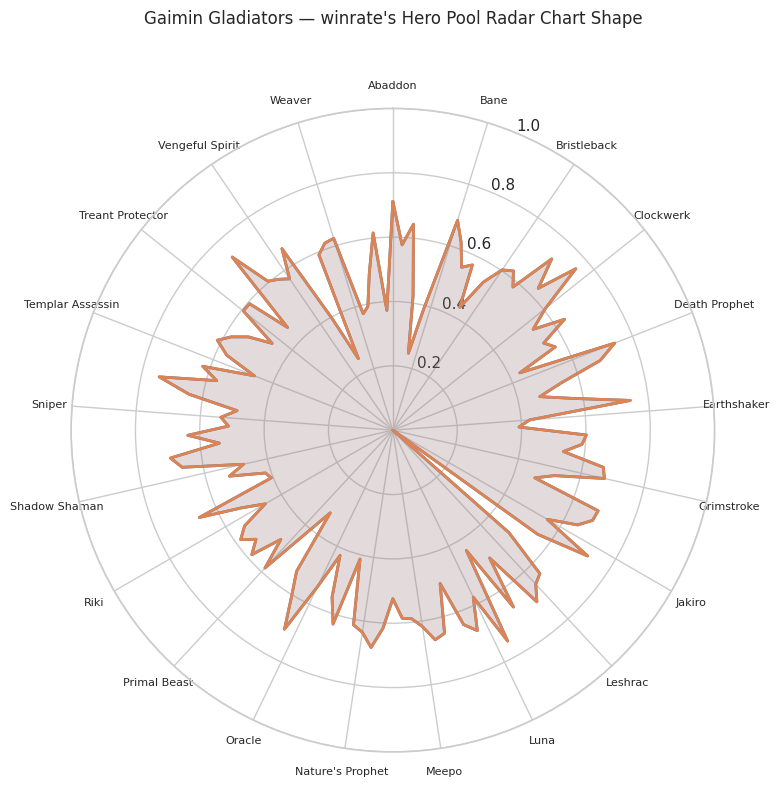

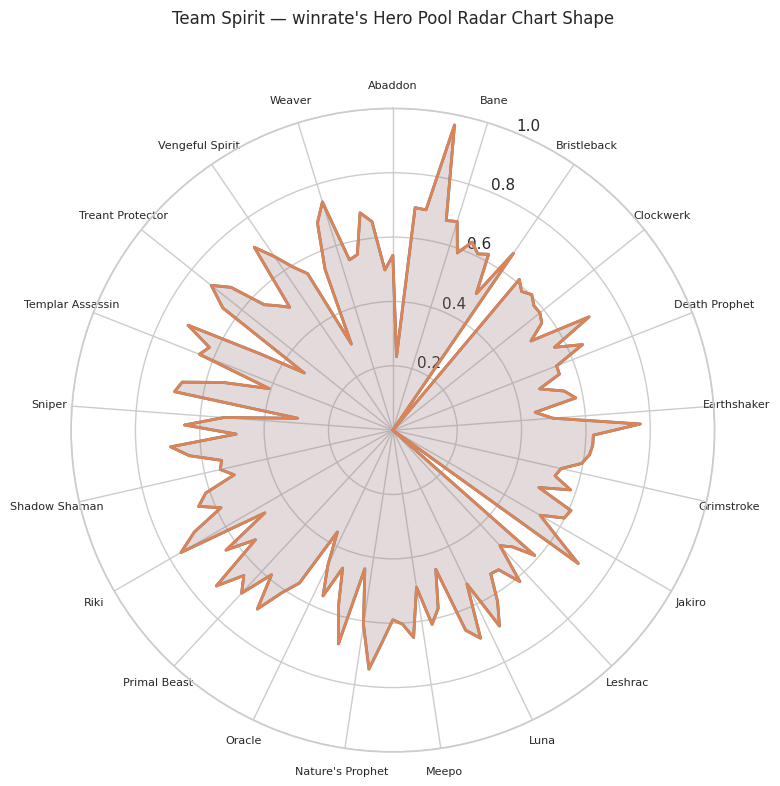

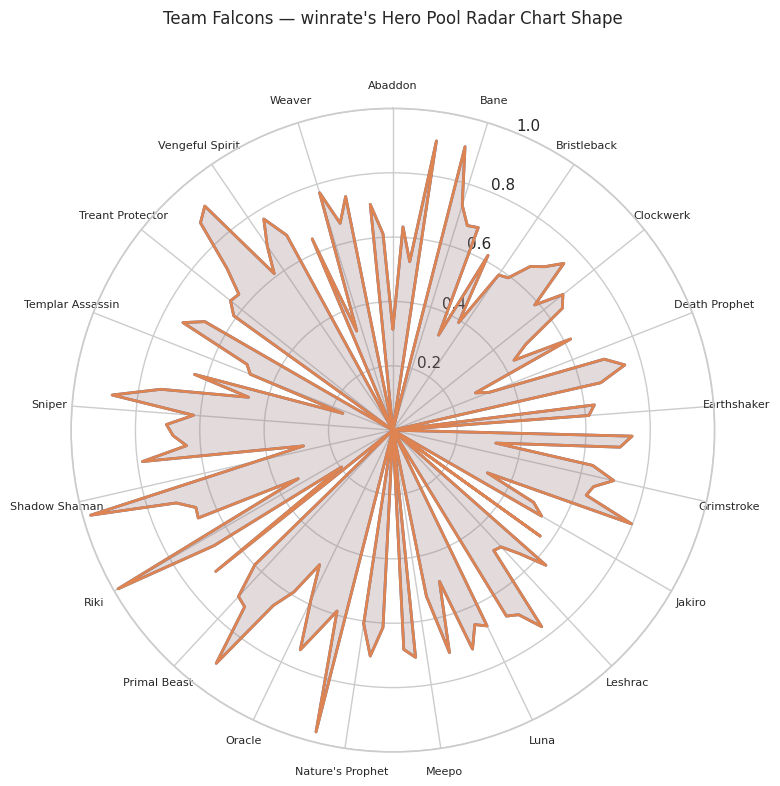

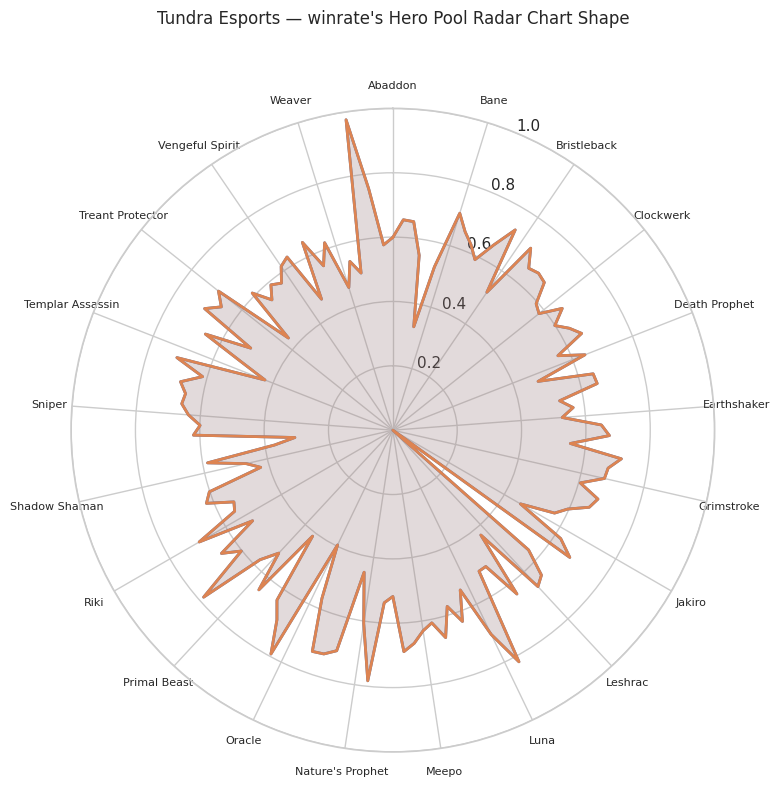

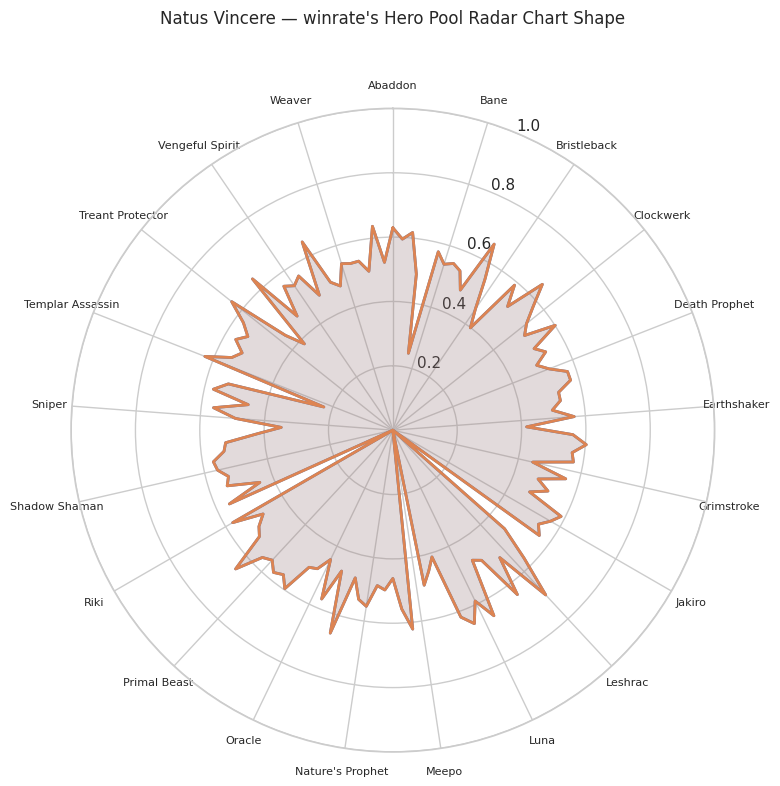

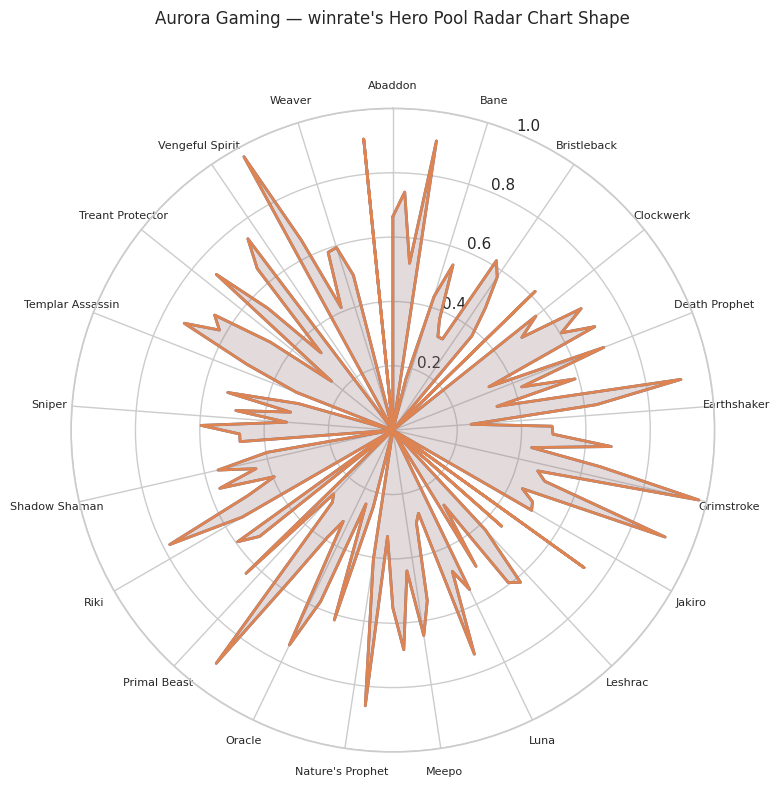

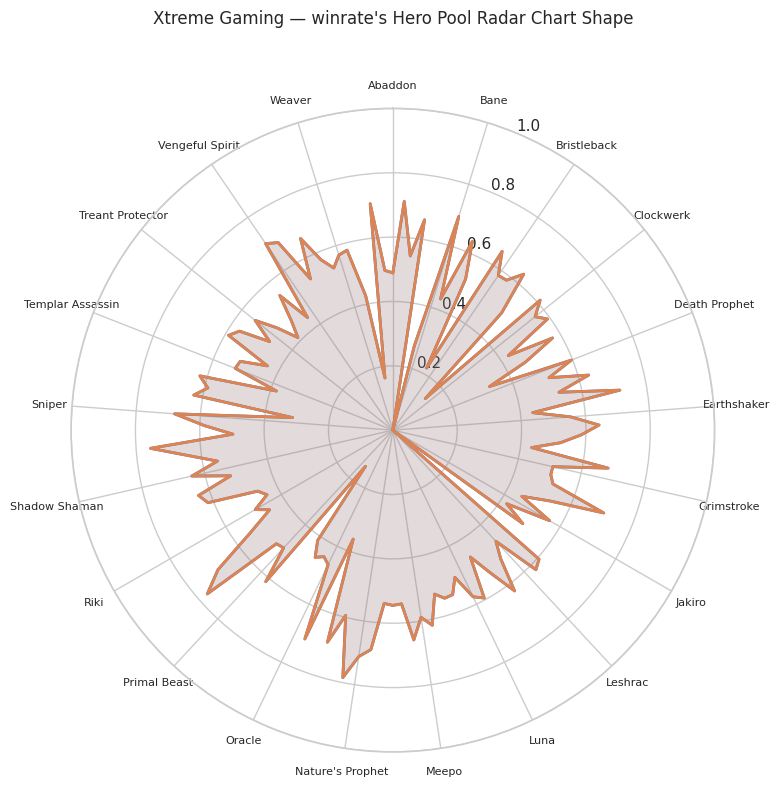

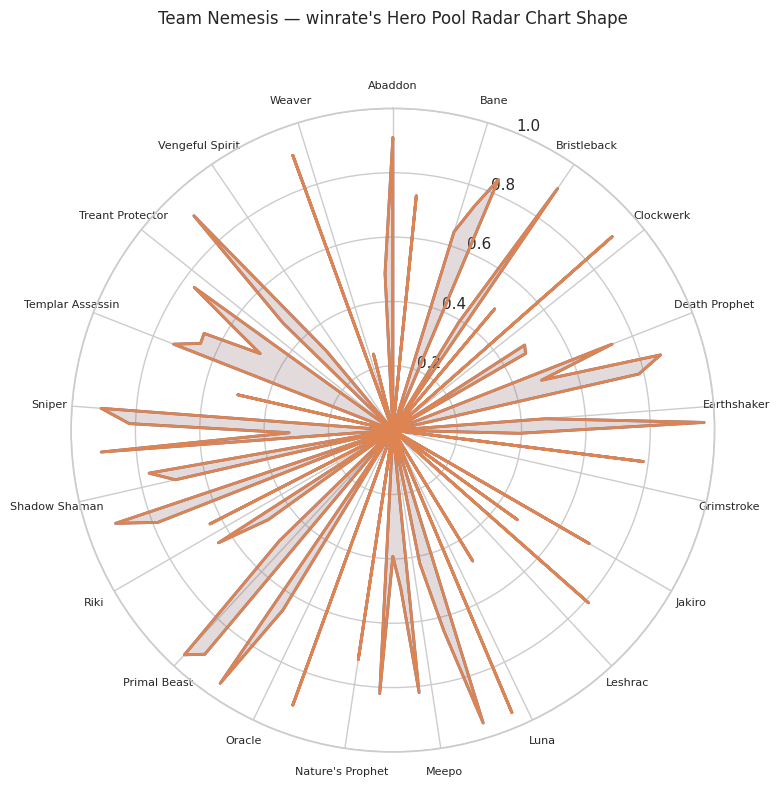

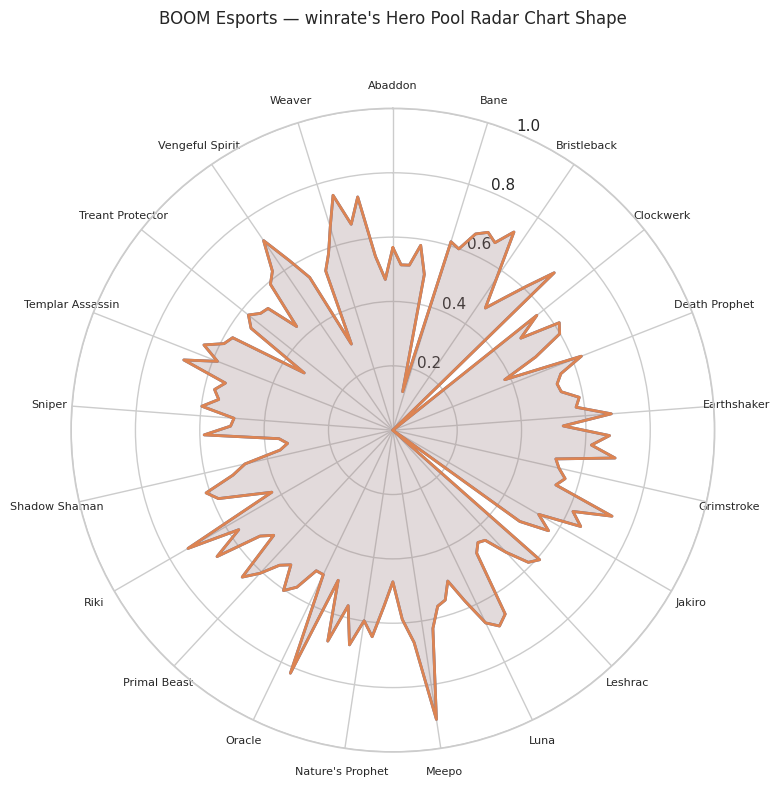

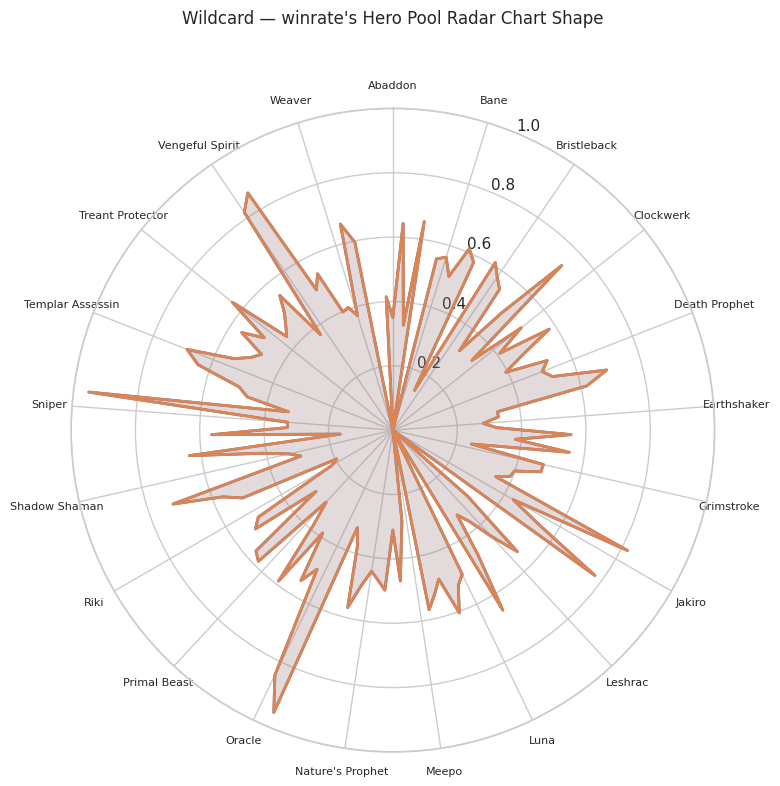

In [106]:
teams_df = list_teams()
teams_df.head(20)  # see names

# Example single team
# plot_team_radar("Team Liquid", value_col="winrate", all_heroes=True,show_every=63)
{
  "teams": [
    { "name": "Team Liquid",         "team_id": 2163,    "invitation_type": "direct_invite", "seed": 1 },
    { "name": "PARIVISION",          "team_id": 9572001, "invitation_type": "direct_invite", "seed": 2 },
    { "name": "BetBoom Team",        "team_id": 8255888, "invitation_type": "direct_invite", "seed": 3 },
    { "name": "Team Tidebound",      "team_id": 9640842, "invitation_type": "direct_invite", "seed": 4 },
    { "name": "Gaimin Gladiators",   "team_id": 8599101, "invitation_type": "direct_invite", "seed": 5 },
    { "name": "Team Spirit",         "team_id": 7119388, "invitation_type": "direct_invite", "seed": 6 },
    { "name": "Team Falcons",        "team_id": 9247354, "invitation_type": "direct_invite", "seed": 7 },
    { "name": "Tundra Esports",      "team_id": 8291895, "invitation_type": "direct_invite", "seed": 8 },
    { "name": "Natus Vincere",       "team_id": 36,      "invitation_type": "regional_qualifier", "seed": 9 },
    { "name": "Nigma Galaxy",        "team_id": 7554697, "invitation_type": "regional_qualifier", "seed": 10 },
    { "name": "Aurora Gaming",       "team_id": 9467224, "invitation_type": "regional_qualifier", "seed": 11 },
    { "name": "Xtreme Gaming",       "team_id": 8261500, "invitation_type": "regional_qualifier", "seed": 12 },
    { "name": "Team Nemesis",        "team_id": 9691969, "invitation_type": "regional_qualifier", "seed": 13 },
    { "name": "BOOM Esports",        "team_id": 7732977, "invitation_type": "regional_qualifier", "seed": 14 },
    { "name": "Wildcard",            "team_id": 8606828, "invitation_type": "regional_qualifier", "seed": 15 },
    { "name": "HEROIC",              "team_id": 9303484, "invitation_type": "regional_qualifier", "seed": 16 }
  ]
}
ti2025 = ["PARIVISION", "Team Liquid", "BetBoom Team", "Team Tidebound", "Gaimin Gladiators", "Team Spirit",  "Team Falcons", "Tundra Esports", "Natus Vincere",  "Nigma Galaxy",  "Aurora Gaming", "Xtreme Gaming","Team Nemesis", "BOOM Esports","Wildcard","HEROIC"]
print(str(len(ti2025)))

for i in ti2025:
  plot_team_radar(i, value_col="winrate", all_heroes=True,show_every=6)


# Example multi-team
# plot_multi_team_radar(ti2025, value_col="winrate", show_every=63, all_heroes=True, mode="intersection")


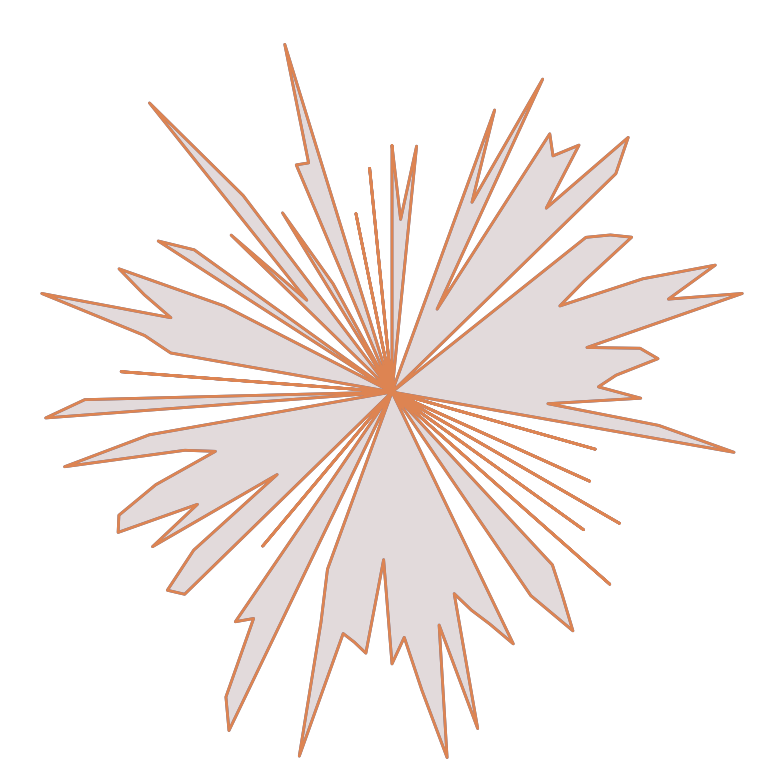

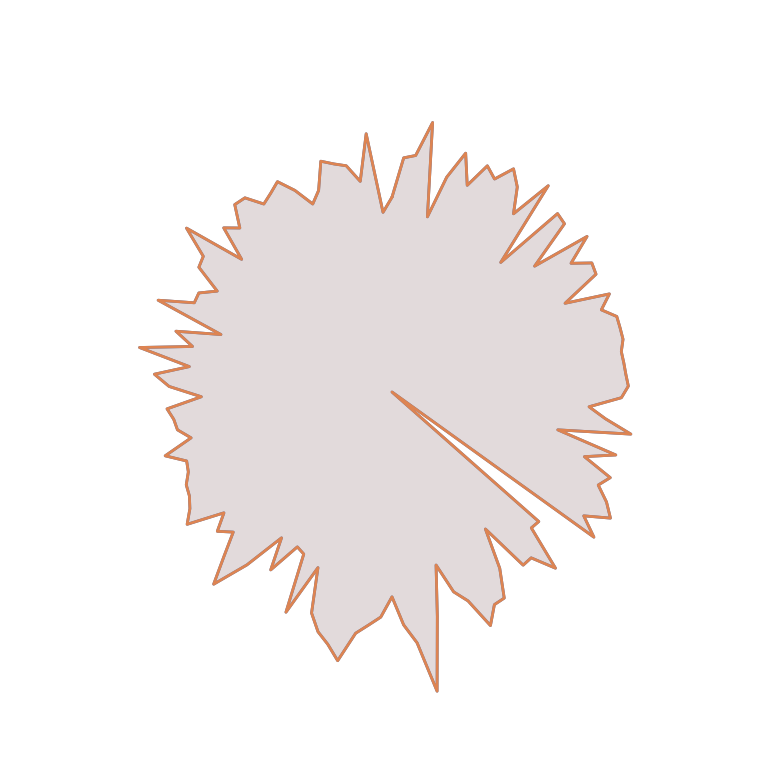

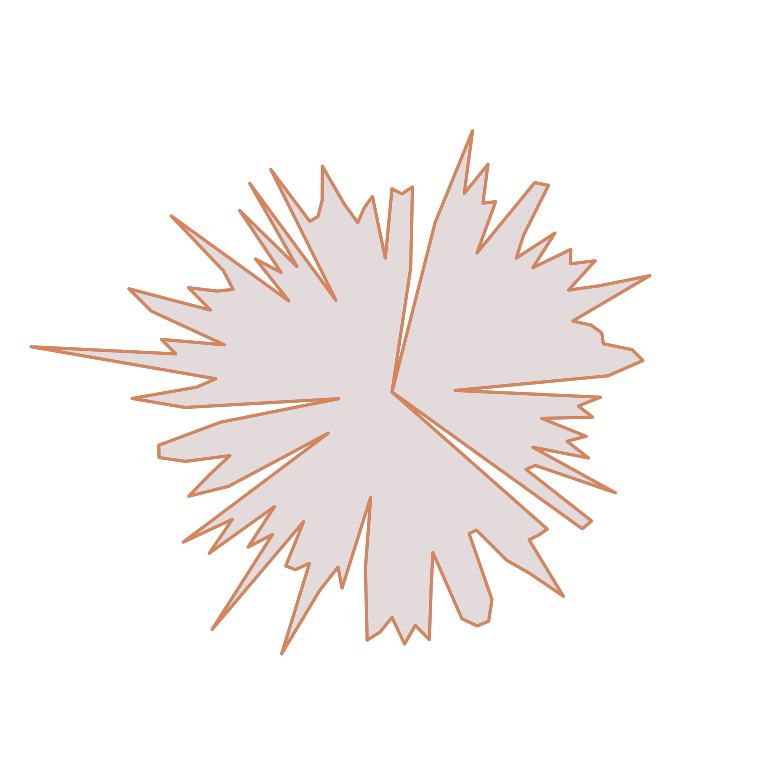

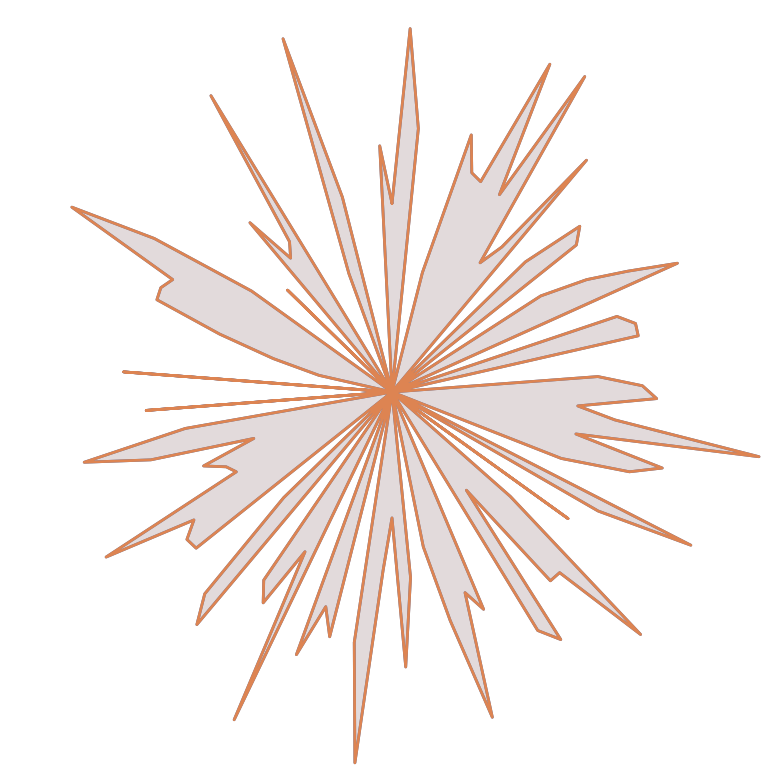

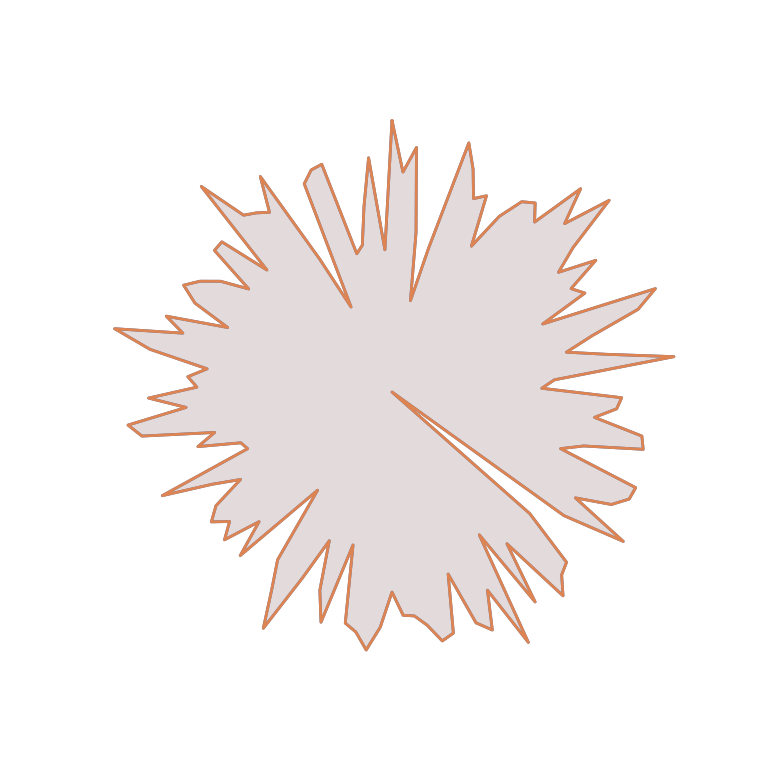

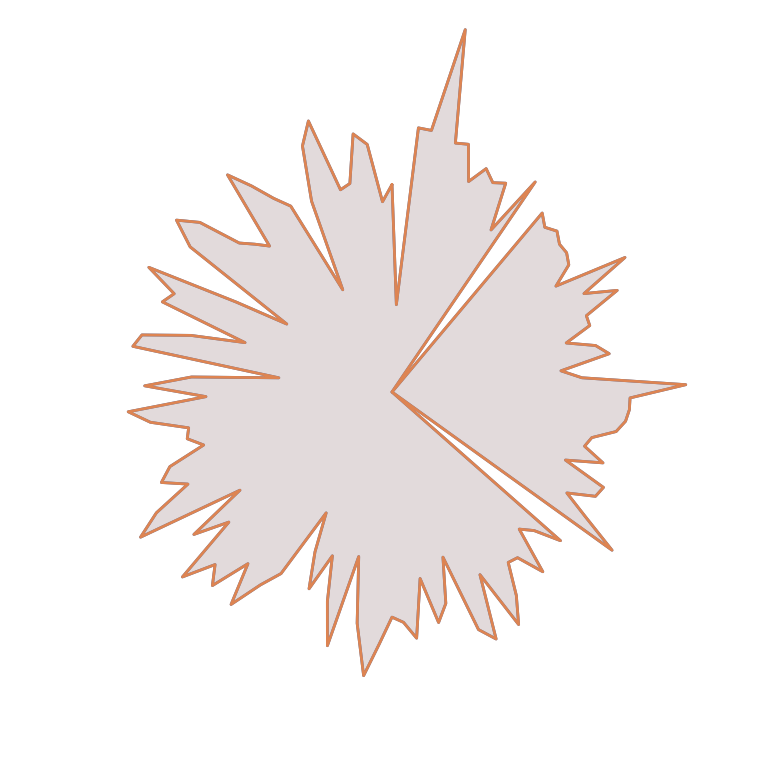

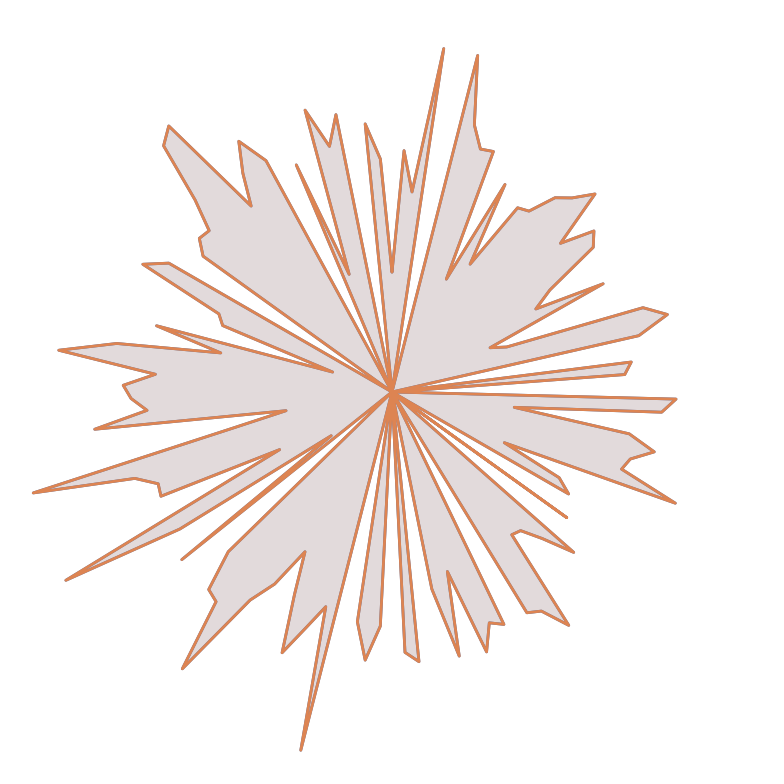

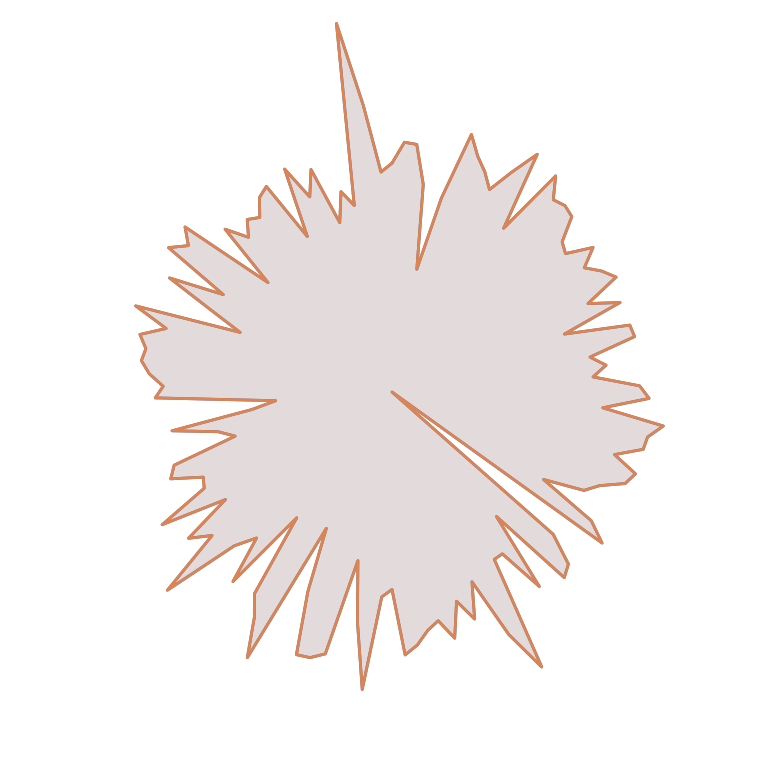

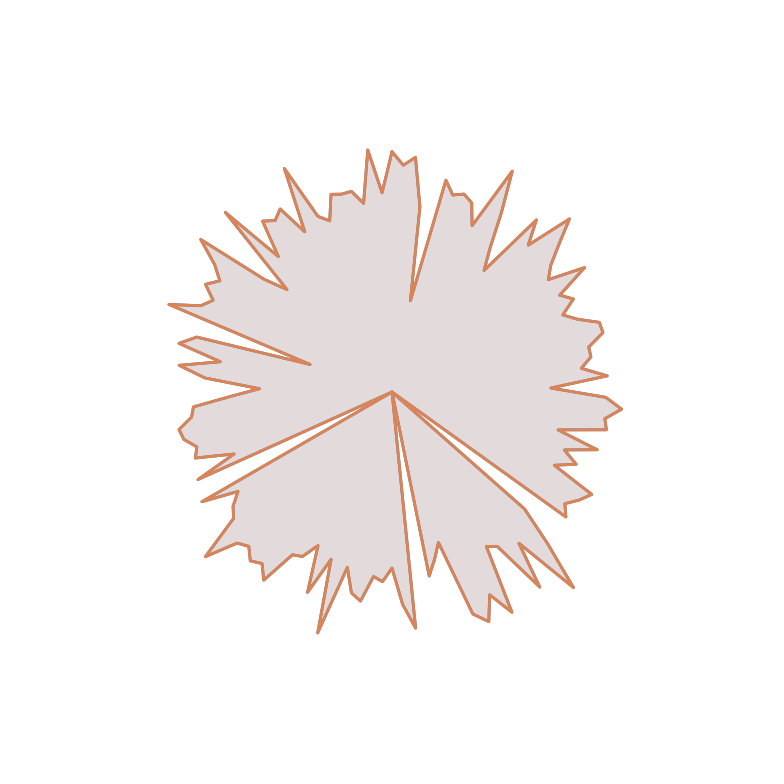

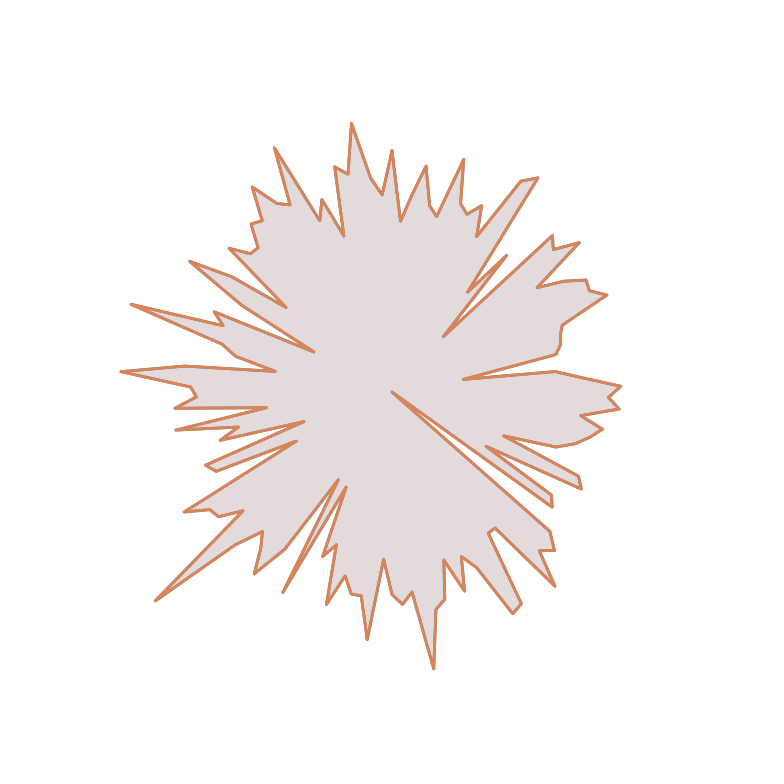

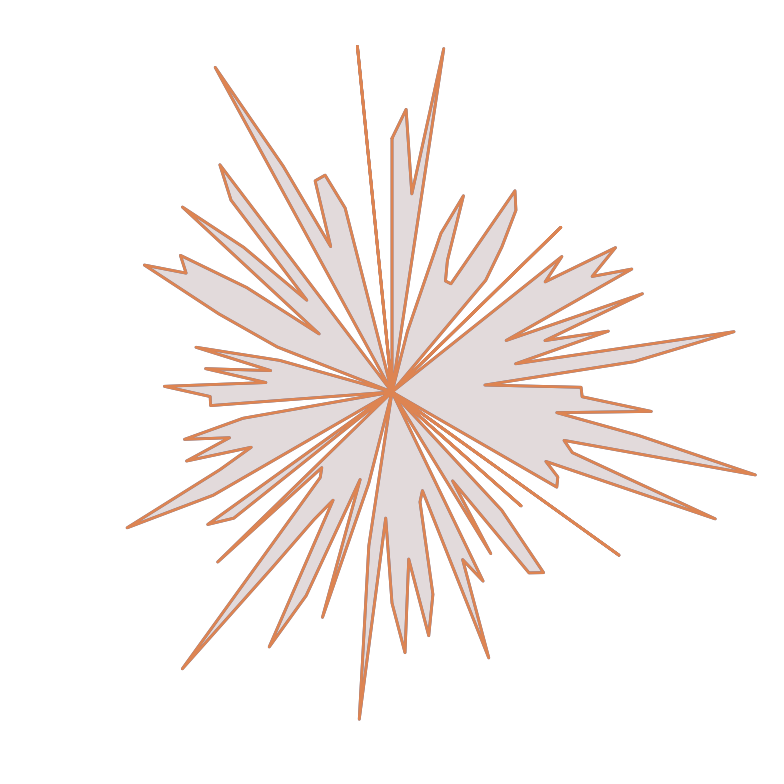

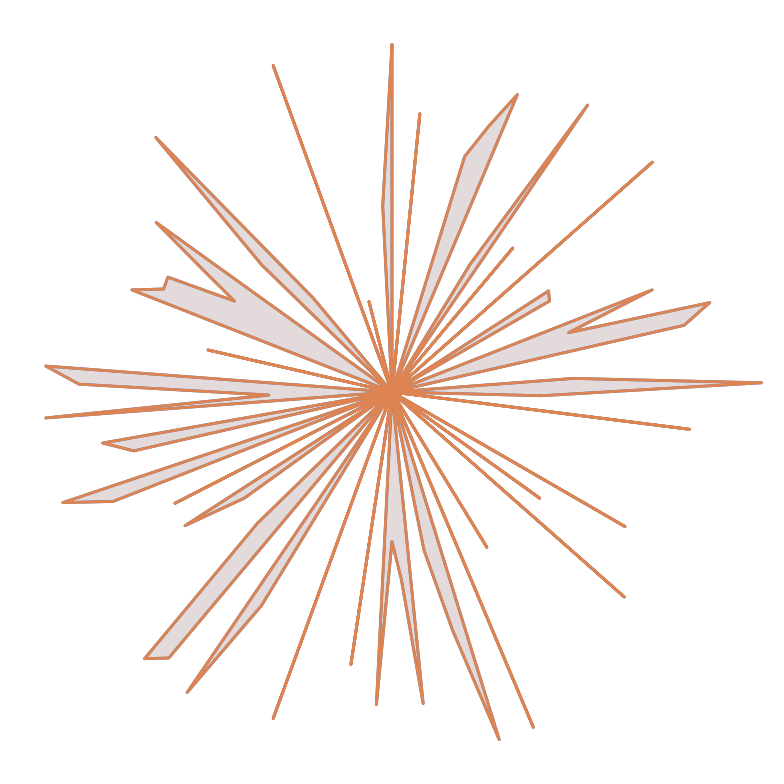

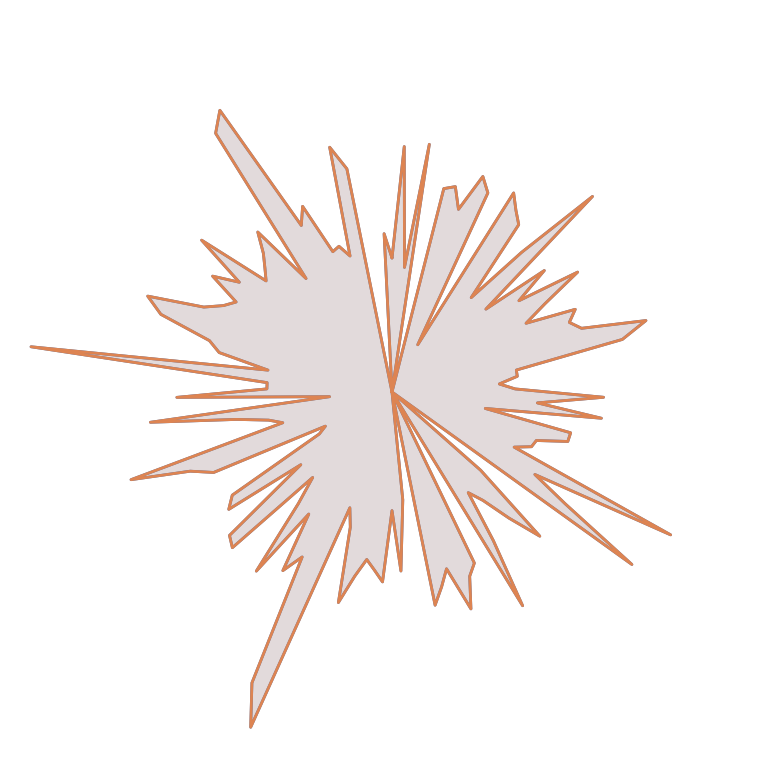

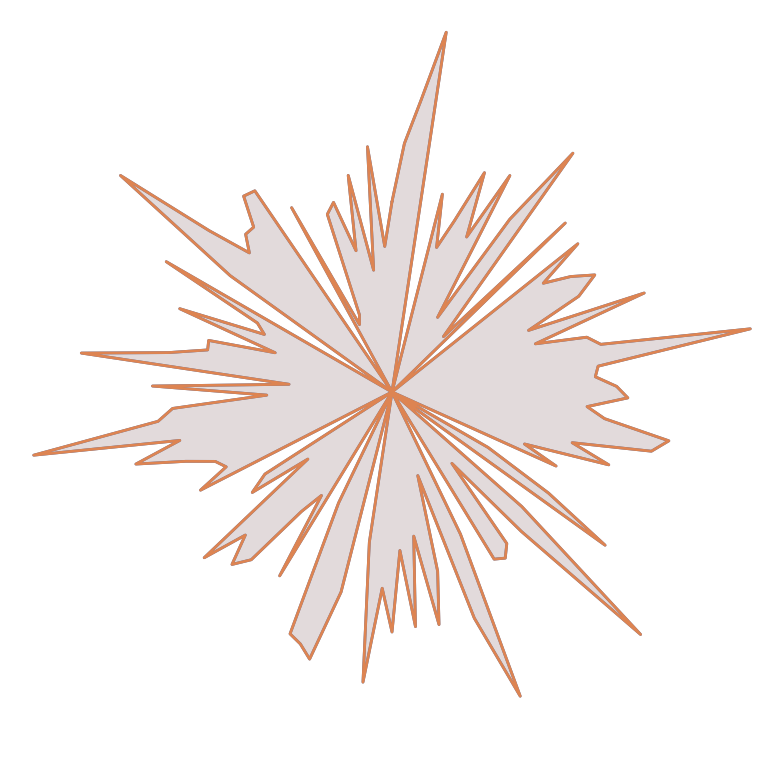

In [107]:
for i in ti2025:
  plot_team_radar(i,all_heroes=True, show_every=126, labelsize=0,show_title=False,
                    show_hero_labels=False,   # theta labels around the circle
                    show_r_ticks=False,       # radial tick labels (0.2, 0.4, …)
                    show_grid=False,
                    show_frame=False,         # polar outer circle
                    axis_off=False,          # master kill switch
                    fill_alpha=0.15,
                    line_width=2)

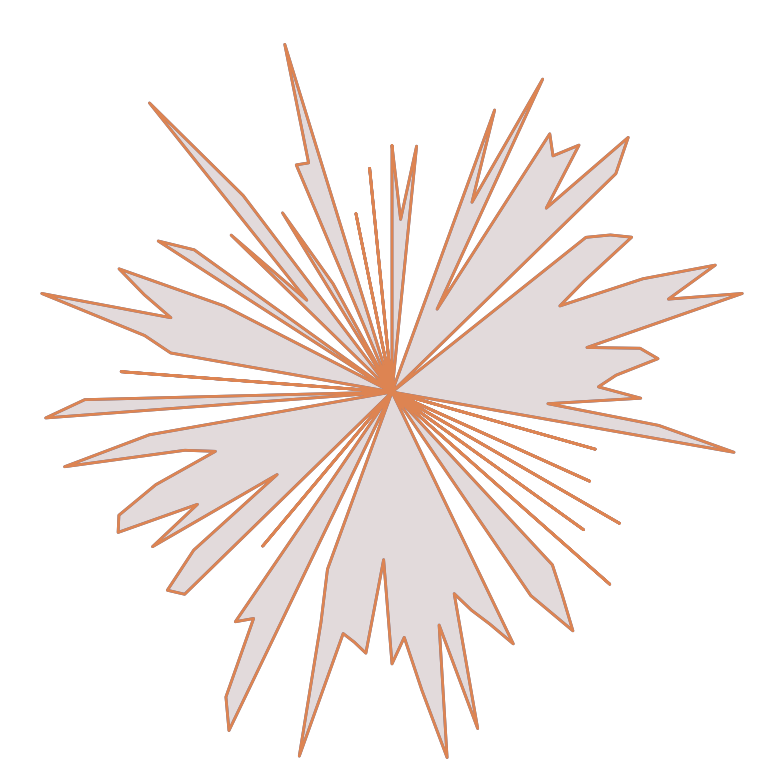

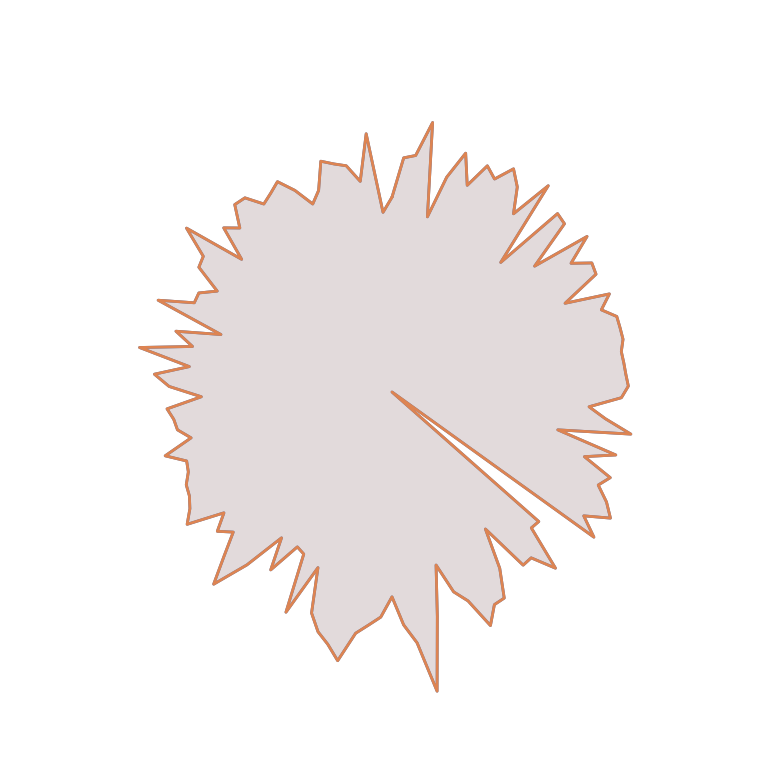

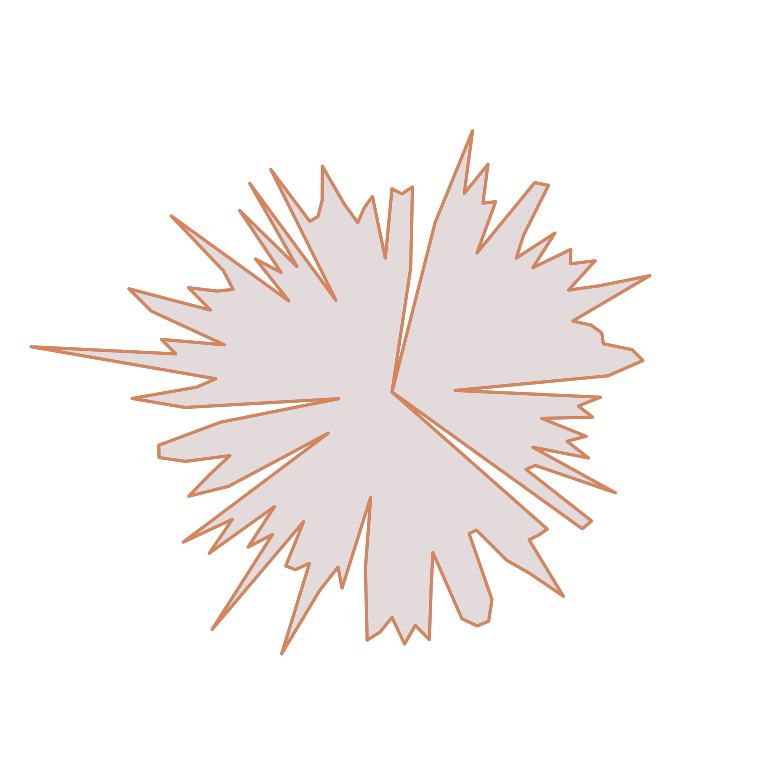

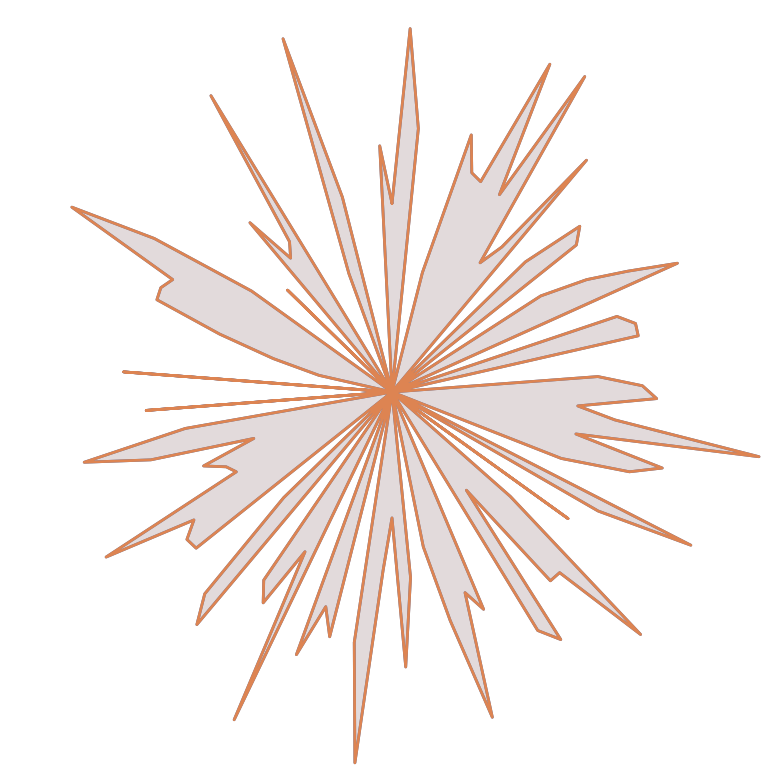

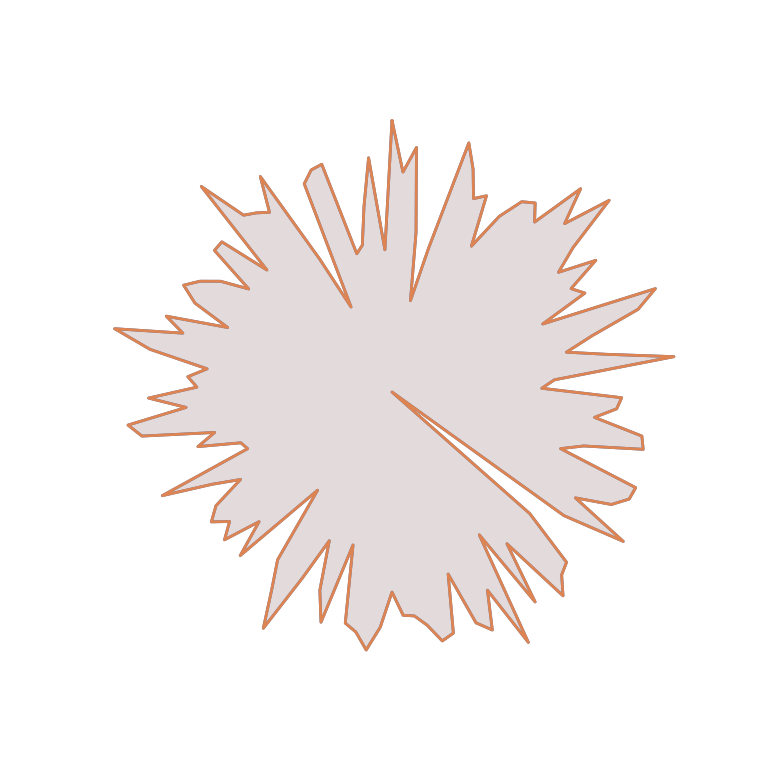

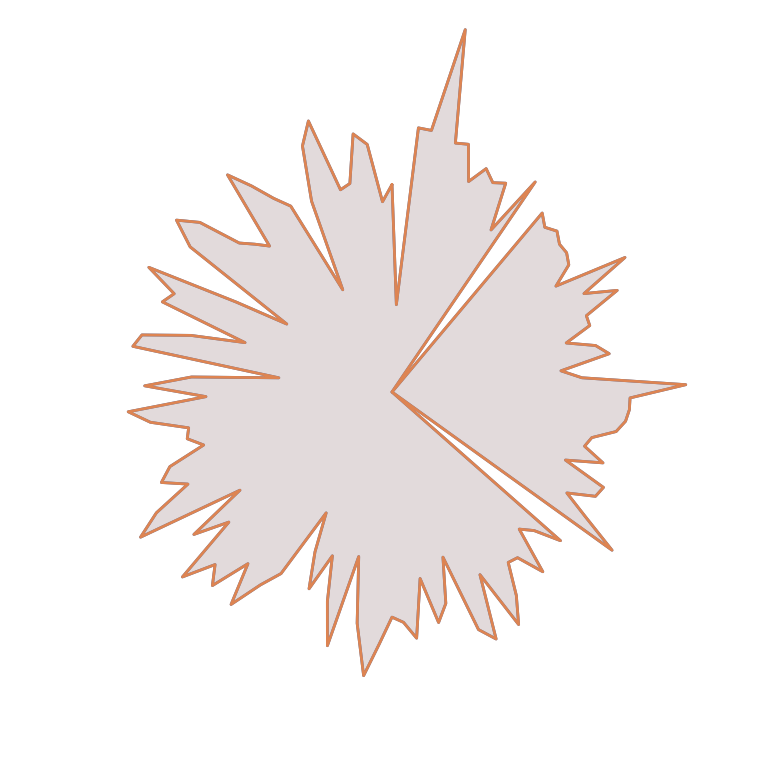

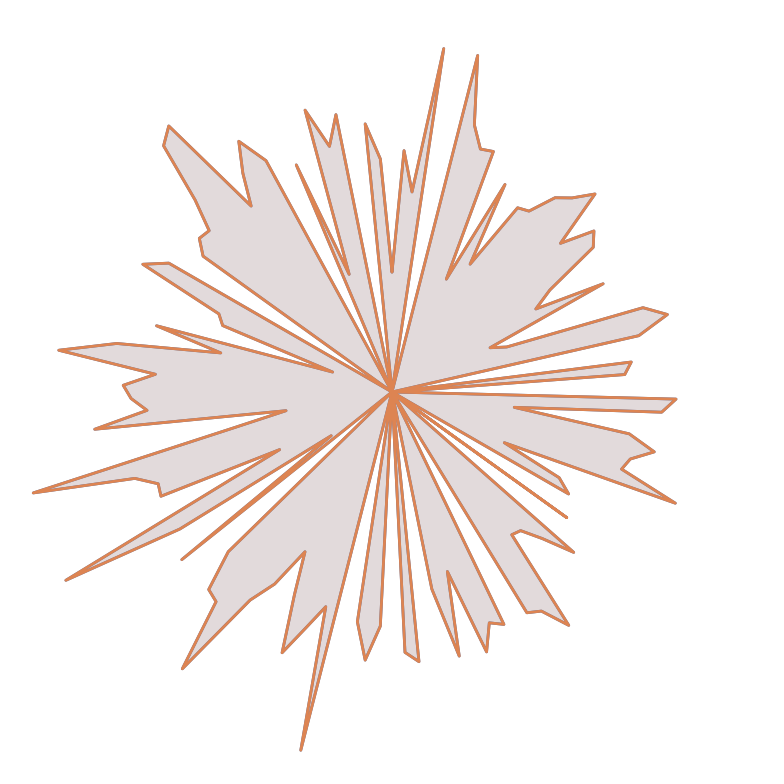

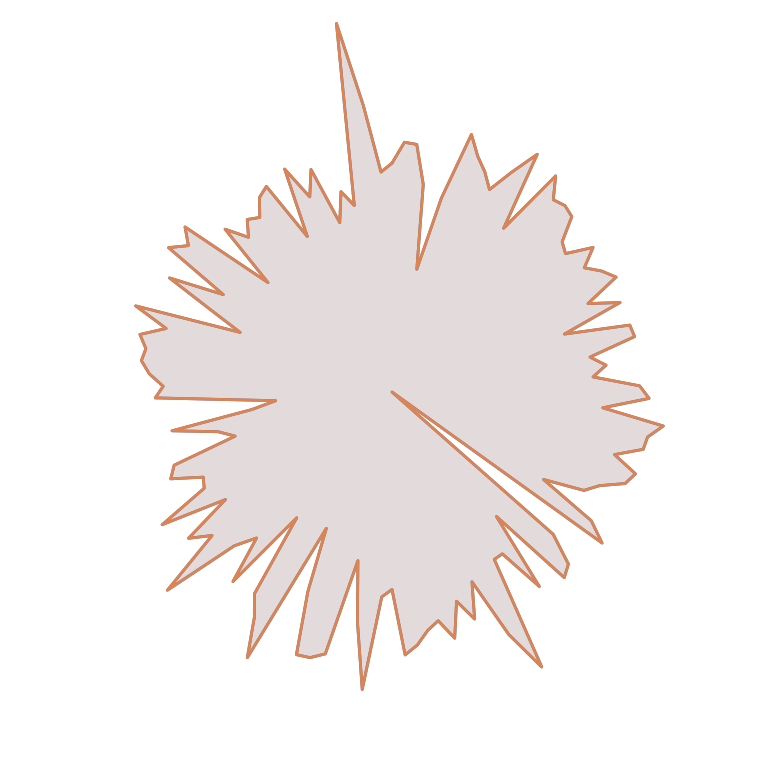

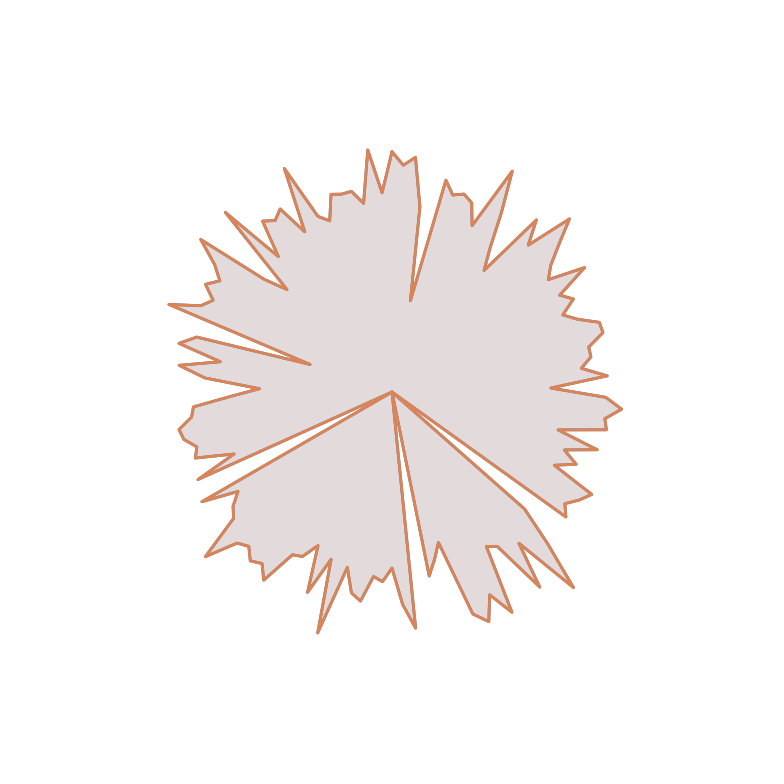

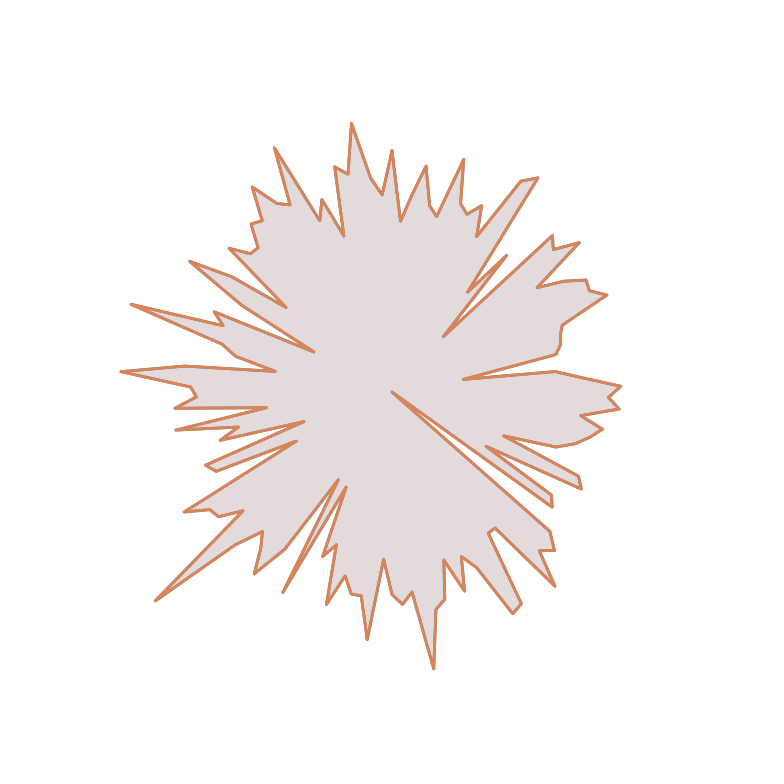

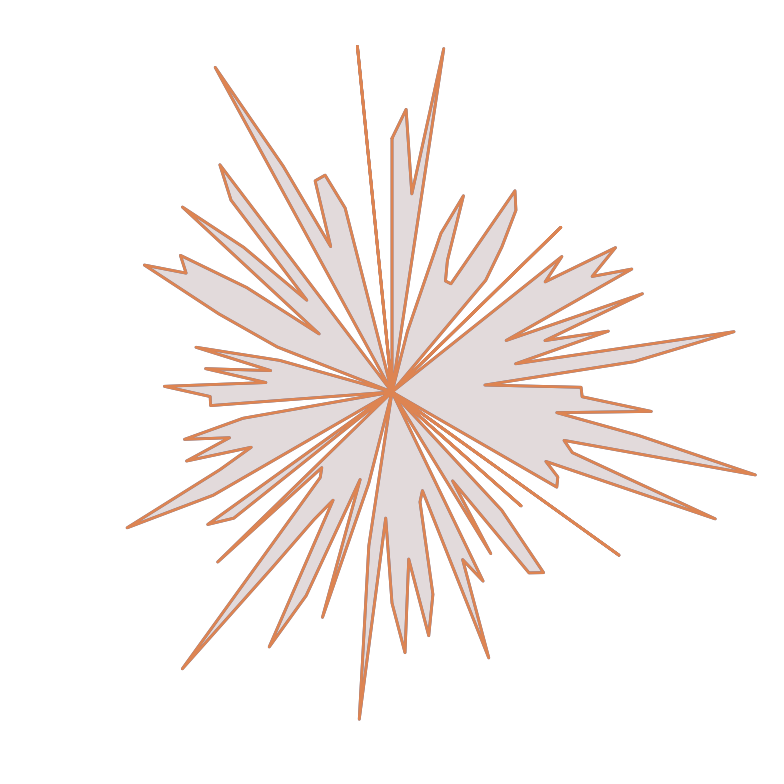

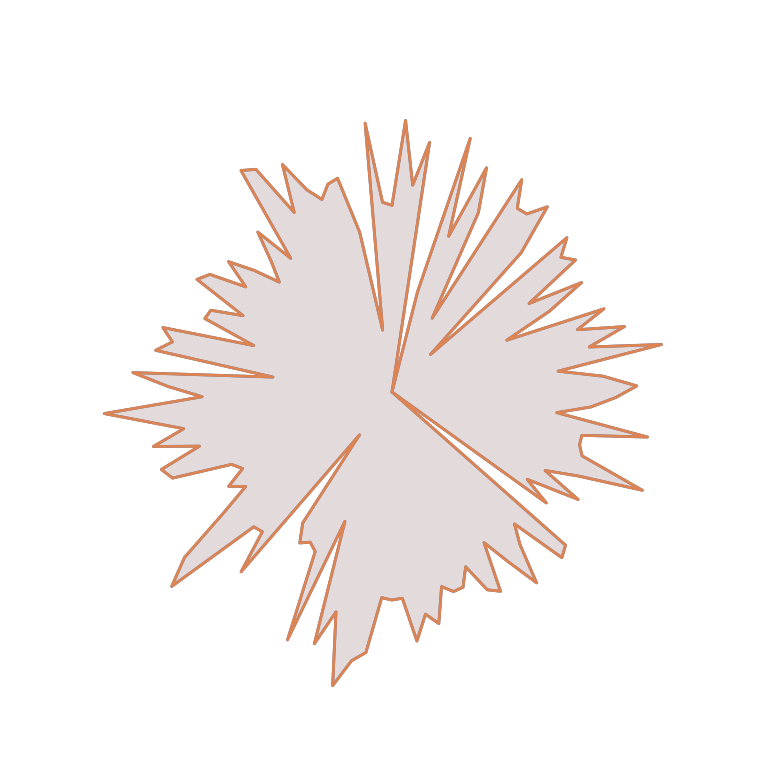

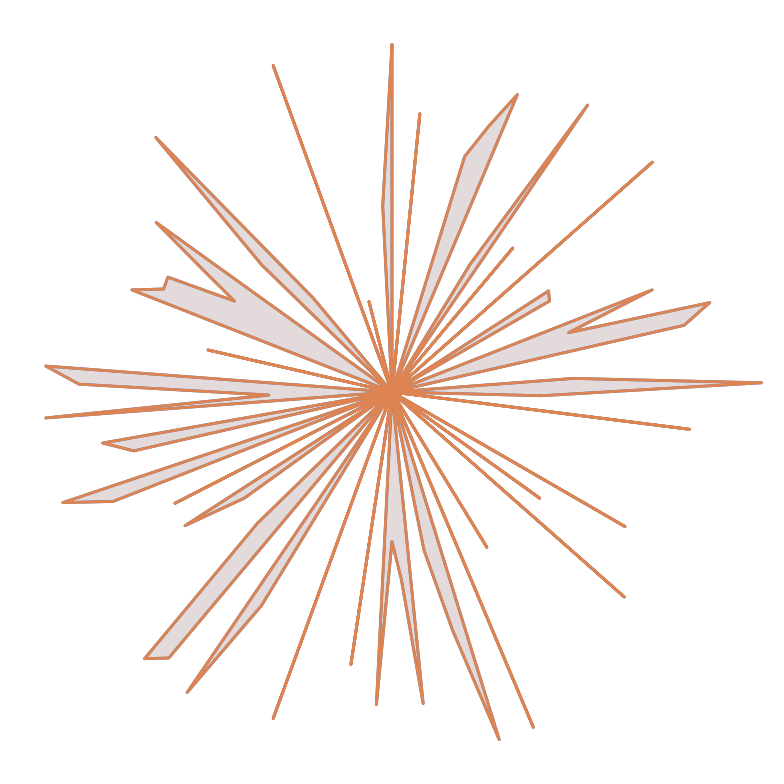

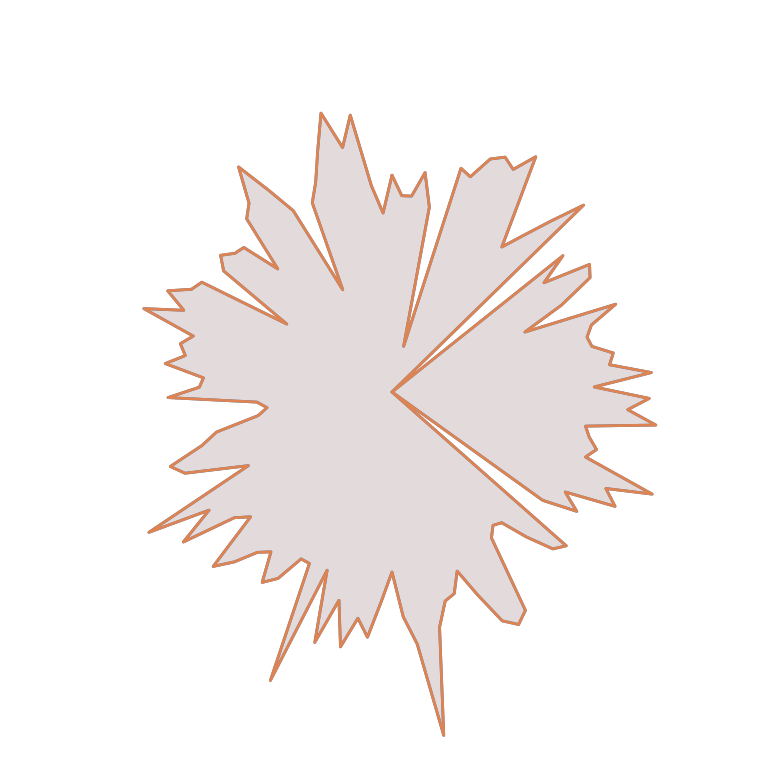

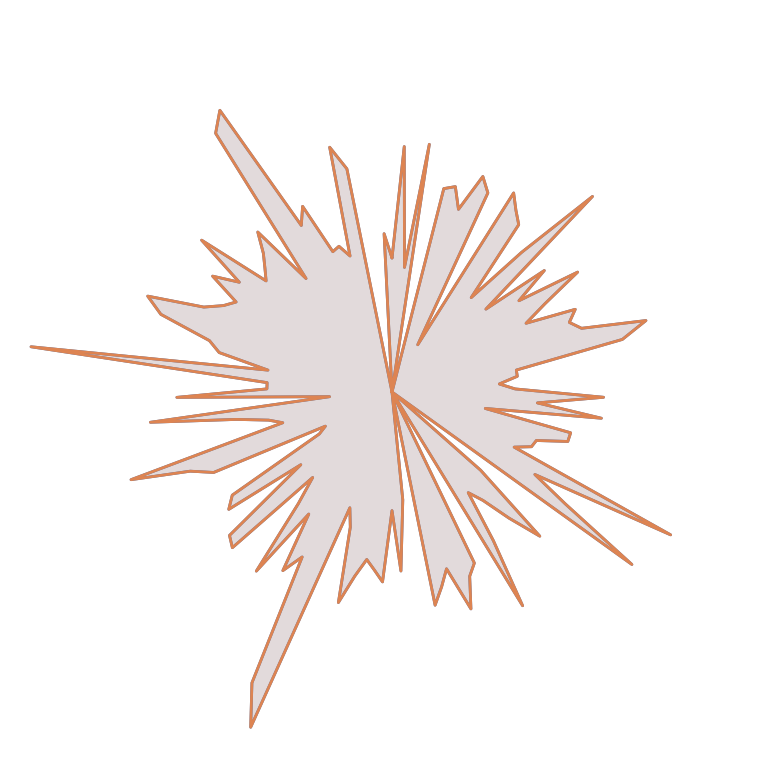

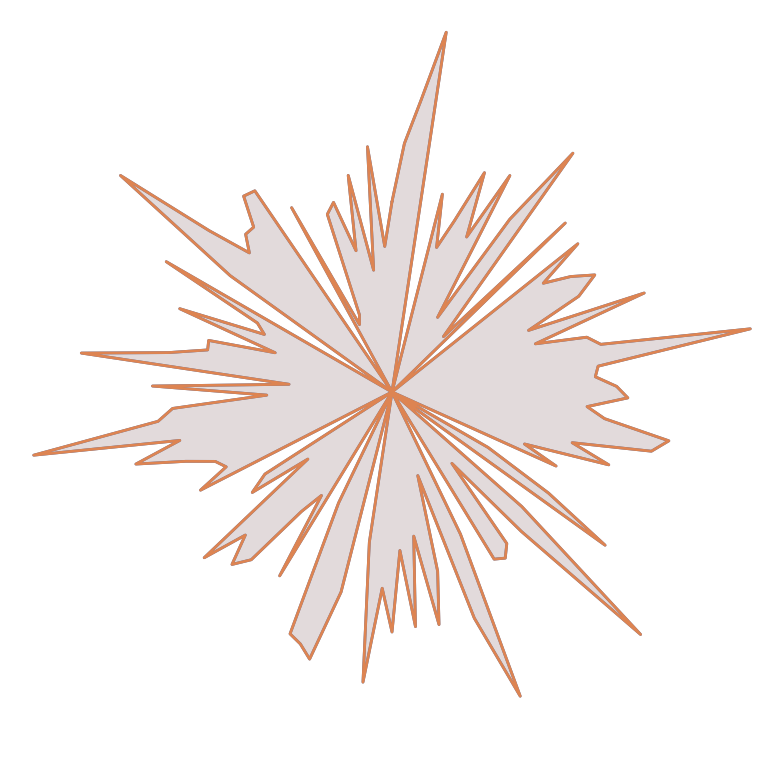

In [110]:
def sanitize(name):
    s = re.sub(r'[^A-Za-z0-9_.-]+', '_', str(name)).strip('_')
    return s or 'team'

outdir = "radar_svgs"
os.makedirs(outdir, exist_ok=True)

for team in ti2025:
    plot_team_radar(team,
        all_heroes=True, show_every=126, labelsize=0,
        show_title=False, show_hero_labels=False, show_r_ticks=False,
        show_grid=False, show_frame=False, axis_off=False,
        fill_alpha=0.15, line_width=2)

    fig = plt.gcf()  # current figure
    fig.savefig(f"{outdir}/{sanitize(team)}.svg", bbox_inches="tight", transparent=True)
    # also PNG if you want:
    # fig.savefig(f"{outdir}/{sanitize(team)}.png", dpi=300, bbox_inches="tight", transparent=True)
    plt.close(fig)   # avoid memory bloat